In [1]:
# Three helpers functions are used to preprocess the dataset, plot diagrams and to perform wavelet packet decompositions
# please check them under the helpers folder
from helpers.DatasetProcess import dataset_to_df
from helpers.PlotExtension import norm_to_plot, img_plot
from helpers.WaveletPacket import wpt_dec, plot_wpt_nodes, plot_wpt_fun, wavelet_families

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sn

# Pytorch is used to build the model
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn import CrossEntropyLoss

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau , CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from tqdm import tqdm
import time

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, recall_score, f1_score

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(7444889600, 8589410304)

### First: Load the Dataset and Get Some Statistics

In [4]:
# Define the Path of the Model
model_type = "vit"
weights_folder_path = "../weights"
model_folder = "CIFAKE"

checkpoint_folder = "WPT-ViT_Compare"

In [34]:
# file name of the saved model
fname1 = f"WPT-ViT_db2_L3P1H18E1S0B500D32_CIFAKE_ph1_lastEp200_acc65.53"
fname2 = f"WPT-ViT_db2_L3P1H18E1S0B1000D32_CIFAKE_ph1_lastEp200_acc92.42"
fname3 = f"WPT-ViT_db2_L3P1H18E1S0B2000D32_CIFAKE_ph1_lastEp200_acc87.63"
fname4 = f"WPT-ViT_db2_L3P1H18E1S1B1000D32_CIFAKE_ph1_lastEp200_acc91.62"

fname_lst = [fname1, fname2, fname3, fname4]

In [35]:
label_lst=["500Epch","1000Epch","2000Epch","1000Epch_sliced"]

In [36]:
model_state_path = f"{weights_folder_path}/{model_folder}/{checkpoint_folder}/"

In [37]:
checkpoint = [""]*len(fname_lst)
for i in range(len(fname_lst)):
    checkpoint[i] = torch.load(model_state_path+fname_lst[i])

In [38]:
best_acc_ofModel=[""]*len(fname_lst)
models_epoch_lst_ofModel=[""]*len(fname_lst)
tr_loss_lst_ofModel=[""]*len(fname_lst)
tr_acc_lst_ofModel=[""]*len(fname_lst)
val_loss_lst_ofModel=[""]*len(fname_lst)
val_acc_lst_ofModel=[""]*len(fname_lst)
accumulate_duration_lst_ofModel=[""]*len(fname_lst)

In [39]:
for i in range(len(fname_lst)):
    best_acc_ofModel[i] = checkpoint[i]['best_acc']
    models_epoch_lst_ofModel[i] = checkpoint[i]['epoch_lst']
    tr_loss_lst_ofModel[i] = checkpoint[i]['tr_loss_lst']
    tr_acc_lst_ofModel[i] = checkpoint[i]['tr_acc_lst']
    val_loss_lst_ofModel[i] = checkpoint[i]['val_loss_lst']
    val_acc_lst_ofModel[i] = checkpoint[i]['val_acc_lst']
    accumulate_duration_lst_ofModel[i] = checkpoint[i]['accumulate_duration_lst']

In [40]:
grid_step = 20

In [41]:
x= range(len(tr_loss_lst_ofModel[0]))

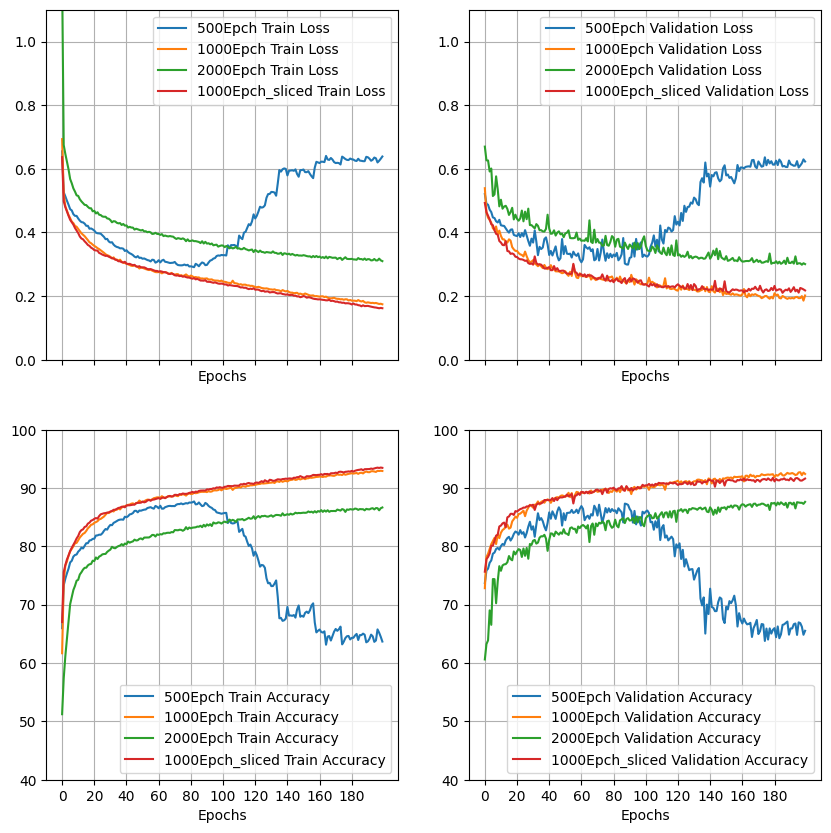

In [42]:
fig, axs = plt.subplots(2, 2,sharex=True,figsize=(10,10))

axs[0,0].plot(x, tr_loss_lst_ofModel[0], label=label_lst[0]+' Train Loss')
axs[0,0].plot(x, tr_loss_lst_ofModel[1], label=label_lst[1]+' Train Loss')
axs[0,0].plot(x, tr_loss_lst_ofModel[2], label=label_lst[2]+' Train Loss')
axs[0,0].plot(x, tr_loss_lst_ofModel[3], label=label_lst[3]+' Train Loss')
axs[0,0].grid(True)
axs[0,0].set_ylim([0, 1.1])
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


axs[0,1].plot(x, val_loss_lst_ofModel[0], label=label_lst[0]+' Validation Loss')
axs[0,1].plot(x, val_loss_lst_ofModel[1], label=label_lst[1]+' Validation Loss')
axs[0,1].plot(x, val_loss_lst_ofModel[2], label=label_lst[2]+' Validation Loss')
axs[0,1].plot(x, val_loss_lst_ofModel[3], label=label_lst[3]+' Validation Loss')
axs[0,1].grid(True)
axs[0,1].set_ylim([0, 1.1])
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


axs[1,0].plot(x, tr_acc_lst_ofModel[0], label=label_lst[0]+' Train Accuracy')
axs[1,0].plot(x, tr_acc_lst_ofModel[1], label=label_lst[1]+' Train Accuracy')
axs[1,0].plot(x, tr_acc_lst_ofModel[2], label=label_lst[2]+' Train Accuracy')
axs[1,0].plot(x, tr_acc_lst_ofModel[3], label=label_lst[3]+' Train Accuracy')
axs[1,0].grid(True)
axs[1,0].set_ylim([40, 100])
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


axs[1,1].plot(x, val_acc_lst_ofModel[0], label=label_lst[0]+' Validation Accuracy')
axs[1,1].plot(x, val_acc_lst_ofModel[1], label=label_lst[1]+' Validation Accuracy')
axs[1,1].plot(x, val_acc_lst_ofModel[2], label=label_lst[2]+' Validation Accuracy')
axs[1,1].plot(x, val_acc_lst_ofModel[3], label=label_lst[3]+' Validation Accuracy')
axs[1,1].grid(True)
axs[1,1].set_ylim([40, 100])
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_xticks(np.arange(0, x[-1]+1, step=grid_step))


plt.show()